<a href="https://colab.research.google.com/github/segnig/Zindi-Competitions/blob/main/outsmarting-outbreaks-challenge/OutsmartingOutbreaks_StarterNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from scipy.spatial import cKDTree

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


In [198]:
FILE_PATH = "/content/drive/MyDrive/Data Science/outsmarting-outbreaks-challenge20241207-28044-iehqcg/"

In [199]:
# Load datasets
train = pd.read_csv(FILE_PATH + "Train.csv")
test = pd.read_csv(FILE_PATH + "Test.csv")
toilets = pd.read_csv(FILE_PATH + "toilets.csv")
waste_management = pd.read_csv(FILE_PATH + "waste_management.csv")
water_sources = pd.read_csv(FILE_PATH + "water_sources.csv")

In [200]:
train.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Dysentery,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Typhoid,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267
2,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Diarrhea,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
3,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Diarrhea,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
4,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Diarrhea,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267


In [201]:

test.head()

,Location,Disease,Month,Category_Health_Facility_UUID,Year,Transformed_Latitude,Transformed_Longitude,ID
0,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,1,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_1_2023_Diarrhea
1,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,2,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_2_2023_Diarrhea
2,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,3,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_3_2023_Diarrhea
3,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,4,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_4_2023_Diarrhea
4,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,5,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_5_2023_Diarrhea


In [202]:
# shape of train dataset and test dataset
print("shape of train datase =", train.shape)
print("shape of test datase =", test.shape)

shape of train datase = (23848, 9)
shape of test datase = (4872, 8)


In [203]:

VariableDefinitions = pd.read_csv(FILE_PATH + "VariableDefinitions.txt", delimiter=" - ", header=None, names=["Variable", "Definition"]).set_index("Variable")
VariableDefinitions.loc["10v", :]

,10v
Definition,Meridional wind component at 10 meters above the surface (north-south direction)


## Toilets Dataset

In [204]:
# toilets
toilets.head()

,Year,Month,10u,10v,2d,2t,evabs,evaow,evatc,evavt,albedo,lshf,lai_hv,lai_lv,pev,ro,src,skt,es,stl1,stl2,stl3,stl4,ssro,slhf,ssr,str,sp,sro,sshf,ssrd,strd,e,tp,swvl1,swvl2,swvl3,swvl4,Transformed_Latitude,Transformed_Longitude,Month_Year,lat_lon,Month_Year_lat_lon
0,2019,1,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,0.173221,0.650001,4.65320,1.83179,-0.011989,0.000733,0.000156,297.997,0.000000e+00,298.603,298.523,298.289,297.740,0.000046,-11278500,17200800,-2832560,93281.6,0.000687,-3023910,20804400,35736900,-0.004510,0.006655,0.346542,0.335724,0.264359,0.300018,-8.61768,68.24536,1_2019,-8.61768_68.24536,1_2019_-8.61768_68.24536
1,2019,2,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,0.173808,0.650001,4.69336,1.86926,-0.014829,0.000130,0.000089,298.747,0.000000e+00,299.313,299.147,298.695,298.043,0.000032,-10918800,18471600,-3363790,93276.6,0.000098,-4069570,22357700,35563400,-0.004366,0.003201,0.254517,0.259918,0.281769,0.296188,-8.61768,68.24536,2_2019,-8.61768_68.24536,2_2019_-8.61768_68.24536
2,2019,3,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,0.178823,0.650001,4.70898,1.88391,-0.013882,0.000382,0.000122,298.860,0.000000e+00,299.530,299.447,299.179,298.451,0.000027,-10572900,18304800,-3516510,93255.8,0.000354,-4169910,22291000,35467300,-0.004228,0.004682,0.278152,0.284195,0.261597,0.291672,-8.61768,68.24536,3_2019,-8.61768_68.24536,3_2019_-8.61768_68.24536
3,2019,4,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,0.180959,0.650017,4.77283,1.94531,-0.008219,0.000922,0.000234,297.100,2.328310e-10,297.811,297.933,298.283,298.588,0.000025,-9375320,13806700,-2404380,93336.3,0.000898,-2148780,16857400,35712800,-0.003749,0.007518,0.385513,0.378616,0.309784,0.288925,-8.61768,68.24536,4_2019,-8.61768_68.24536,4_2019_-8.61768_68.24536
4,2019,5,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,0.182375,0.650009,4.79968,1.97473,-0.005983,0.000712,0.000253,295.070,0.000000e+00,295.789,296.044,296.812,298.102,0.000086,-7440870,10437000,-2010550,93536.6,0.000626,-1242840,12764000,35080400,-0.002975,0.005989,0.397659,0.400055,0.392654,0.309311,-8.61768,68.24536,5_2019,-8.61768_68.24536,5_2019_-8.61768_68.24536


## Water sources

In [205]:
water_sources.head()

,Year,Month,10u,10v,2d,2t,evabs,evaow,evatc,evavt,albedo,lshf,lai_hv,lai_lv,pev,ro,src,skt,es,stl1,stl2,stl3,stl4,ssro,slhf,ssr,str,sp,sro,sshf,ssrd,strd,e,tp,swvl1,swvl2,swvl3,swvl4,Transformed_Latitude,Transformed_Longitude,Month_Year,lat_lon,Month_Year_lat_lon
0,2019,1,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,0.173221,0.650001,4.65320,1.83179,-0.011989,0.000733,0.000156,297.997,0.000000e+00,298.603,298.523,298.289,297.740,0.000046,-11278500,17200800,-2832560,93281.6,0.000687,-3023910,20804400,35736900,-0.004510,0.006655,0.346542,0.335724,0.264359,0.300018,-8.57424,68.23761,1_2019,-8.57424_68.23761,1_2019_-8.57424_68.23761
1,2019,2,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,0.173808,0.650001,4.69336,1.86926,-0.014829,0.000130,0.000089,298.747,0.000000e+00,299.313,299.147,298.695,298.043,0.000032,-10918800,18471600,-3363790,93276.6,0.000098,-4069570,22357700,35563400,-0.004366,0.003201,0.254517,0.259918,0.281769,0.296188,-8.57424,68.23761,2_2019,-8.57424_68.23761,2_2019_-8.57424_68.23761
2,2019,3,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,0.178823,0.650001,4.70898,1.88391,-0.013882,0.000382,0.000122,298.860,0.000000e+00,299.530,299.447,299.179,298.451,0.000027,-10572900,18304800,-3516510,93255.8,0.000354,-4169910,22291000,35467300,-0.004228,0.004682,0.278152,0.284195,0.261597,0.291672,-8.57424,68.23761,3_2019,-8.57424_68.23761,3_2019_-8.57424_68.23761
3,2019,4,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,0.180959,0.650017,4.77283,1.94531,-0.008219,0.000922,0.000234,297.100,2.328310e-10,297.811,297.933,298.283,298.588,0.000025,-9375320,13806700,-2404380,93336.3,0.000898,-2148780,16857400,35712800,-0.003749,0.007518,0.385513,0.378616,0.309784,0.288925,-8.57424,68.23761,4_2019,-8.57424_68.23761,4_2019_-8.57424_68.23761
4,2019,5,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,0.182375,0.650009,4.79968,1.97473,-0.005983,0.000712,0.000253,295.070,0.000000e+00,295.789,296.044,296.812,298.102,0.000086,-7440870,10437000,-2010550,93536.6,0.000626,-1242840,12764000,35080400,-0.002975,0.005989,0.397659,0.400055,0.392654,0.309311,-8.57424,68.23761,5_2019,-8.57424_68.23761,5_2019_-8.57424_68.23761


In [206]:
VariableDefinitions

,Definition
Variable,
10u,Zonal wind component at 10 meters above the surface (east-west direction)
10v,Meridional wind component at 10 meters above the surface (north-south direction)
2d,Dew point temperature at 2 meters above the surface
2t,Air temperature at 2 meters above the surface
evabs,Evaporation from bare soil
...,...
tp,Total precipitation
swvl1,Volumetric soil water layer 1 (moisture in the top soil layer)
swvl2,Volumetric soil water layer 2 (moisture in the second soil layer)


In [207]:
# Combine train and test datasets for consistent preprocessing
hospital_data = pd.concat([train, test])

In [208]:
# Look at informtion of train and test dataset
hospital_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28720 entries, 0 to 4871
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             28720 non-null  object 
 1   Total                          23847 non-null  float64
 2   Location                       28720 non-null  object 
 3   Category_Health_Facility_UUID  28720 non-null  object 
 4   Disease                        28720 non-null  object 
 5   Month                          28720 non-null  int64  
 6   Year                           28720 non-null  int64  
 7   Transformed_Latitude           28720 non-null  float64
 8   Transformed_Longitude          28720 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.2+ MB


In [209]:
hospital_data["Location"].head()

,Location
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018
2,ID_3a11929e-3317-476d-99f7-1bd9fb58f018
3,ID_3a11929e-3317-476d-99f7-1bd9fb58f018
4,ID_3a11929e-3317-476d-99f7-1bd9fb58f018


In [210]:
hospital_data[["Transformed_Latitude", "Transformed_Longitude"]].head()

,Transformed_Latitude,Transformed_Longitude
0,-8.62982,68.23267
1,-8.62982,68.23267
2,-8.62982,68.23267
3,-8.62982,68.23267
4,-8.62982,68.23267


In [211]:
hospital_data[["Transformed_Latitude", "Transformed_Longitude"]].describe()

,Transformed_Latitude,Transformed_Longitude
count,28720.000000,28720.000000
mean,-8.611957,68.242122
std,0.042428,0.028995
min,-8.713760,68.169720
25%,-8.626560,68.224740
50%,-8.617400,68.237620
75%,-8.594310,68.254900
max,-8.496810,68.328390


In [212]:
toilets.head()

,Year,Month,10u,10v,2d,2t,evabs,evaow,evatc,evavt,albedo,lshf,lai_hv,lai_lv,pev,ro,src,skt,es,stl1,stl2,stl3,stl4,ssro,slhf,ssr,str,sp,sro,sshf,ssrd,strd,e,tp,swvl1,swvl2,swvl3,swvl4,Transformed_Latitude,Transformed_Longitude,Month_Year,lat_lon,Month_Year_lat_lon
0,2019,1,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,0.173221,0.650001,4.65320,1.83179,-0.011989,0.000733,0.000156,297.997,0.000000e+00,298.603,298.523,298.289,297.740,0.000046,-11278500,17200800,-2832560,93281.6,0.000687,-3023910,20804400,35736900,-0.004510,0.006655,0.346542,0.335724,0.264359,0.300018,-8.61768,68.24536,1_2019,-8.61768_68.24536,1_2019_-8.61768_68.24536
1,2019,2,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,0.173808,0.650001,4.69336,1.86926,-0.014829,0.000130,0.000089,298.747,0.000000e+00,299.313,299.147,298.695,298.043,0.000032,-10918800,18471600,-3363790,93276.6,0.000098,-4069570,22357700,35563400,-0.004366,0.003201,0.254517,0.259918,0.281769,0.296188,-8.61768,68.24536,2_2019,-8.61768_68.24536,2_2019_-8.61768_68.24536
2,2019,3,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,0.178823,0.650001,4.70898,1.88391,-0.013882,0.000382,0.000122,298.860,0.000000e+00,299.530,299.447,299.179,298.451,0.000027,-10572900,18304800,-3516510,93255.8,0.000354,-4169910,22291000,35467300,-0.004228,0.004682,0.278152,0.284195,0.261597,0.291672,-8.61768,68.24536,3_2019,-8.61768_68.24536,3_2019_-8.61768_68.24536
3,2019,4,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,0.180959,0.650017,4.77283,1.94531,-0.008219,0.000922,0.000234,297.100,2.328310e-10,297.811,297.933,298.283,298.588,0.000025,-9375320,13806700,-2404380,93336.3,0.000898,-2148780,16857400,35712800,-0.003749,0.007518,0.385513,0.378616,0.309784,0.288925,-8.61768,68.24536,4_2019,-8.61768_68.24536,4_2019_-8.61768_68.24536
4,2019,5,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,0.182375,0.650009,4.79968,1.97473,-0.005983,0.000712,0.000253,295.070,0.000000e+00,295.789,296.044,296.812,298.102,0.000086,-7440870,10437000,-2010550,93536.6,0.000626,-1242840,12764000,35080400,-0.002975,0.005989,0.397659,0.400055,0.392654,0.309311,-8.61768,68.24536,5_2019,-8.61768_68.24536,5_2019_-8.61768_68.24536


In [213]:
# Drop unnecessary columns from supplementary datasets
for df in [toilets, waste_management, water_sources]:
    print(df.columns)

Index(['Year', 'Month', '10u', '10v', '2d', '2t', 'evabs', 'evaow', 'evatc',
       'evavt', 'albedo', 'lshf', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src',
       'skt', 'es', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr',
       'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'e', 'tp', 'swvl1', 'swvl2',
       'swvl3', 'swvl4', 'Transformed_Latitude', 'Transformed_Longitude',
       'Month_Year', 'lat_lon', 'Month_Year_lat_lon'],
      dtype='object')
Index(['Year', 'Month', '10u', '10v', '2d', '2t', 'evabs', 'evaow', 'evatc',
       'evavt', 'albedo', 'lshf', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src',
       'skt', 'es', 'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr',
       'str', 'sp', 'sro', 'sshf', 'ssrd', 'strd', 'e', 'tp', 'swvl1', 'swvl2',
       'swvl3', 'swvl4', 'Transformed_Latitude', 'Transformed_Longitude',
       'Month_Year', 'lat_lon', 'Month_Year_lat_lon'],
      dtype='object')
Index(['Year', 'Month', '10u', '10v', '2d', '2t', 'evabs', 'evaow', 'evatc',
       'e

In [214]:
toilets['10u']

,10u
0,-1.006850
1,-1.408560
2,-0.892110
3,-0.392348
4,-0.447104
...,...
10675,-1.061380
10676,-1.492400
10677,-1.590750
10678,-0.877717


In [215]:
VariableDefinitions.loc["10u", :]

,10u
Definition,Zonal wind component at 10 meters above the surface (east-west direction)


In [216]:
from IPython.display import IFrame

# Google Maps embed URL centered on Tanzania
IFrame(
    src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d3976.4100586031256!2d34.88882119999999!3d-6.369028399999999!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x19cf77c7b6c607f1%3A0x3c2557ff9748a5a8!2sTanzania!5e0!3m2!1sen!2sus!4v1700000000000!5m2!1sen!2sus",
    width=600,
    height=600
)


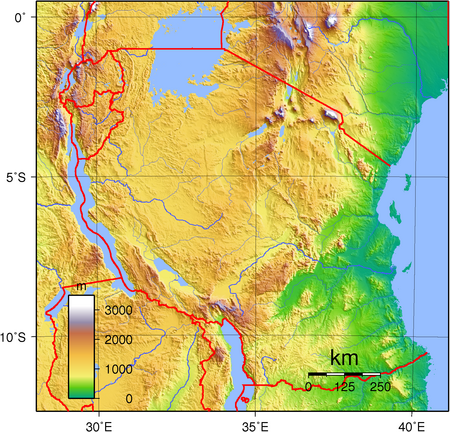

In [217]:
# Image display
from IPython.display import Image
Image("https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Tanzania_Topography.png/450px-Tanzania_Topography.png")

In [218]:
# Rename columns for clarity
def rename_columns(df, prefix):
    for col in df.columns:
        if col not in ['Month_Year_lat_lon', 'lat_lon']:
            df.rename(columns={col: f"{prefix}_{col}"}, inplace=True)

rename_columns(toilets, "toilet")
rename_columns(waste_management, "waste")
rename_columns(water_sources, "water")


In [219]:
# Fill missing values in the 'Total' column
hospital_data['Total'].fillna(0, inplace=True)

In [220]:
# Drop rows with missing latitude and longitude in water sources
water_sources.dropna(subset=['water_Transformed_Latitude'], inplace=True)

In [221]:
# Visualize locations for a specific year and month
# Note the months/year should in the given timeframe [2019, 2023]
def plot_locations(year=2022, month=1, month_name='January'):
    if year < 2019 or year > 2023:
        print("Invalid year. Please choose a year between 2019 and 2023.")
        return

    if month < 1 or month > 12:
        print("Invalid month. Please choose a month between 1 and 12.")
        return

    if month_name.capitalize() not in ['January', 'February', 'March',
                                       'April', 'May', 'June', 'July',
                                       'August', 'September', 'October',
                                       'November', 'December']:
        print("Invalid month name. Please choose from 'January' to 'December'.")
        return

    plt.figure(figsize=(12, 8))
    subsets = [
        (hospital_data.query(f"Year == {year} and Month == {month}"), 'Transformed', 'Hospital', 's'),
        (water_sources.query(f"water_Month_Year == '{month}_{year}'"), 'water_Transformed', 'Water', 'o'),
        (waste_management.query(f"waste_Month_Year == '{month}_{year}'"), 'waste_Transformed', 'Waste', 'x'),
        (toilets.query(f"toilet_Month_Year == '{month}_{year}'"), 'toilet_Transformed', 'Toilet', '^'),
    ]
    for df, prefix, label, marker in subsets:
        plt.scatter(df[f'{prefix}_Longitude'], df[f'{prefix}_Latitude'], label=label, alpha=0.6, marker=marker)
    plt.title(f'Locations ({month_name.capitalize()} {year})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

In [222]:
def find_nearest(hospital_df, location_df, lat_col, lon_col, id_col):
    # Create a cKDTree for efficient nearest neighbour search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    nearest = {}
    # Loop through each hospital and find the nearest site in location_df
    for _, row in hospital_df.iterrows():
        _, idx = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']])
        nearest[row['ID']] = location_df.iloc[idx][id_col]
    return nearest

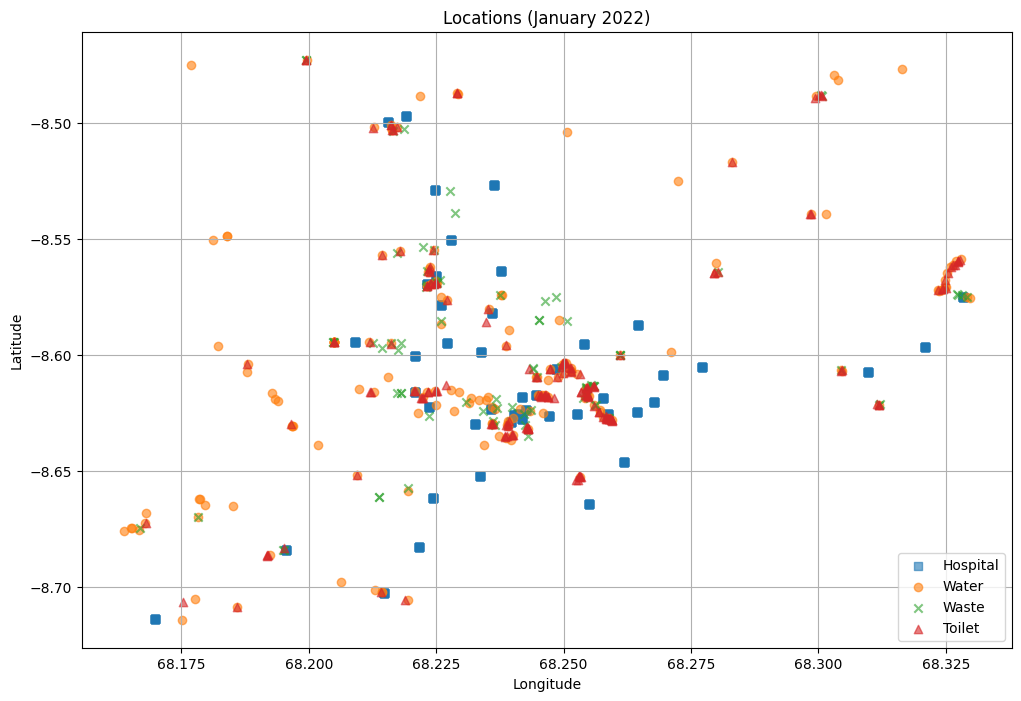

In [223]:
plot_locations()

In [224]:

from IPython.display import IFrame

# Google Maps embed URL centered on Tanzania
IFrame(
    src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d3976.4100586031256!2d34.88882119999999!3d-6.369028399999999!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x19cf77c7b6c607f1%3A0x3c2557ff9748a5a8!2sTanzania!5e0!3m2!1sen!2sus!4v1700000000000!5m2!1sen!2sus",
    width=600,
    height=600
)


In [225]:
def find_nearest(hospital_df, location_df, lat_col, lon_col, id_col):
    # Create a cKDTree for efficient nearest neighbour search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    nearest = {}
    # Loop through each hospital and find the nearest site in location_df
    for _, row in hospital_df.iterrows():
        _, idx = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']])
        nearest[row['ID']] = location_df.iloc[idx][id_col]
    return nearest


In [226]:
# Ensure unique identifier columns exist in all supplementary datasets
for df, prefix in [(toilets, 'toilet'), (waste_management, 'waste'), (water_sources, 'water')]:
    df[f"{prefix}_Month_Year_lat_lon"] = (
        df[f"{prefix}_Month_Year"] + '_' +
        df[f"{prefix}_Transformed_Latitude"].astype(str) + '_' +
        df[f"{prefix}_Transformed_Longitude"].astype(str)
    )

In [227]:
# Merge datasets with nearest locations
merged_data = hospital_data.copy()
datasets = [
    (toilets, 'toilet', 'toilet_Month_Year_lat_lon'),
    (waste_management, 'waste', 'waste_Month_Year_lat_lon'),
    (water_sources, 'water', 'water_Month_Year_lat_lon'),
]

In [228]:
for df, prefix, id_col in datasets:
    nearest = find_nearest(merged_data, df, f"{prefix}_Transformed_Latitude", f"{prefix}_Transformed_Longitude", id_col)
    nearest_df = pd.DataFrame(list(nearest.items()), columns=['ID', id_col])
    print(nearest_df.head())
    merged_data = merged_data.merge(nearest_df, on="ID").merge(df, on=id_col)

                                                                ID  \
0        ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Dysentery   
1          ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Typhoid   
2         ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Diarrhea   
3  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Schistosomiasis   
4          ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Malaria   

  toilet_Month_Year_lat_lon  
0  4_2020_-8.62979_68.23582  
1  4_2020_-8.62979_68.23582  
2  4_2020_-8.62979_68.23582  
3  4_2020_-8.62979_68.23582  
4  4_2020_-8.62979_68.23582  
                                                                ID  \
0        ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Dysentery   
1          ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Typhoid   
2         ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Diarrhea   
3  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Schistosomiasis   
4          ID_3a11929e-3317-476d-99f7-1bd9fb58f01

In [229]:
merged_data.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,toilet_Month_Year_lat_lon,toilet_Year,toilet_Month,toilet_10u,toilet_10v,toilet_2d,toilet_2t,toilet_evabs,toilet_evaow,toilet_evatc,toilet_evavt,toilet_albedo,toilet_lshf,toilet_lai_hv,toilet_lai_lv,toilet_pev,toilet_ro,toilet_src,toilet_skt,toilet_es,toilet_stl1,toilet_stl2,toilet_stl3,toilet_stl4,toilet_ssro,toilet_slhf,toilet_ssr,toilet_str,toilet_sp,toilet_sro,toilet_sshf,toilet_ssrd,toilet_strd,toilet_e,toilet_tp,toilet_swvl1,toilet_swvl2,toilet_swvl3,toilet_swvl4,toilet_Transformed_Latitude,toilet_Transformed_Longitude,toilet_Month_Year,lat_lon_x,Month_Year_lat_lon_x,waste_Month_Year_lat_lon,waste_Year,waste_Month,waste_10u,waste_10v,waste_2d,waste_2t,waste_evabs,waste_evaow,waste_evatc,waste_evavt,waste_albedo,waste_lshf,waste_lai_hv,waste_lai_lv,waste_pev,waste_ro,waste_src,waste_skt,waste_es,waste_stl1,waste_stl2,waste_stl3,waste_stl4,waste_ssro,waste_slhf,waste_ssr,waste_str,waste_sp,waste_sro,waste_sshf,waste_ssrd,waste_strd,waste_e,waste_tp,waste_swvl1,waste_swvl2,waste_swvl3,waste_swvl4,waste_Transformed_Latitude,waste_Transformed_Longitude,waste_Month_Year,lat_lon_y,Month_Year_lat_lon_y,water_Month_Year_lat_lon,water_Year,water_Month,water_10u,water_10v,water_2d,water_2t,water_evabs,water_evaow,water_evatc,water_evavt,water_albedo,water_lshf,water_lai_hv,water_lai_lv,water_pev,water_ro,water_src,water_skt,water_es,water_stl1,water_stl2,water_stl3,water_stl4,water_ssro,water_slhf,water_ssr,water_str,water_sp,water_sro,water_sshf,water_ssrd,water_strd,water_e,water_tp,water_swvl1,water_swvl2,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude,water_Month_Year,lat_lon,Month_Year_lat_lon
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Dysentery,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,2020,4,-0.268989,0.434248,293.688,295.826,-0.001586,-0.000559,-0.001427,-2.514570e-08,0.180957,0.650009,4.77283,1.94531,-0.007145,0.006419,0.000292,296.303,0.0,297.01,297.133,297.461,297.89,0.003894,-8932350,12919600,-2207800,93553.6,0.002524,-1906560,15773400,35506000,-0.003572,0.010136,0.410492,0.412476,0.418381,0.421661,-8.62979,68.23582,4_2020,-8.62979_68.23582,4_2020_-8.62979_68.23582,5_2021_-8.62861_68.23612,2021,5,-0.231009,0.88069,290.091,294.521,-0.00243,-0.000788,-0.00035,-2.747400e-08,0.182368,0.649994,4.79968,1.97473,-0.009929,0.0002,0.000062,294.795,0.0,295.515,295.729,296.361,297.447,0.00018,-8922480,14507500,-3822210,93703.6,0.00002,-1948450,17743800,33066900,-0.003568,0.000982,0.29657,0.321991,0.363693,0.340363,-8.62861,68.23612,5_2021,-8.62861_68.23612,5_2021_-8.62861_68.23612,12_2023_-8.62966_68.23589,2023,12,-1.02042,-0.517984,293.889,297.52,-0.001427,-0.000598,-0.000564,-1.722950e-08,0.172082,0.650001,4.55408,1.7373,-0.007022,0.000287,0.000147,298.302,0.0,298.864,298.698,298.245,297.741,0.000004,-6474240,11130500,-1484820,93346.5,0.000283,-2630750,13444000,18697700,-0.002589,0.002667,0.325867,0.325302,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Typhoid,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,2020,4,-0.268989,0.434248,293.688,295.826,-0.001586,-0.000559,-0.001427,-2.514570e-08,0.180957,0.650009,4.77283,1.94531,-0.007145,0.006419,0.000292,296.303,0.0,297.01,297.133,297.461,297.89,0.003894,-8932350,12919600,-2207800,93553.6,0.002524,-1906560,15773400,35506000,-0.003572,0.010136,0.410492,0.412476,0.418381,0.421661,-8.62979,68.23582,4_2020,-8.62979_68.23582,4_2020_-8.62979_68.23582,5_2021_-8.62861_68.23612,2021,5,-0.231009,0.88069,290.091,294.521,-0.00243,-0.000788,-0.00035,-2.747400e-08,0.182368,0.649994,4.79968,1.97473,-0.009929,0.0002,0.000062,294.795,0.0,295.515,295.729,296.361,297.447,0.0001

In [230]:
float_cols = merged_data.select_dtypes(include=["float64", "int64"]).columns



In [231]:
toilets.columns

Index(['toilet_Year', 'toilet_Month', 'toilet_10u', 'toilet_10v', 'toilet_2d',
       'toilet_2t', 'toilet_evabs', 'toilet_evaow', 'toilet_evatc',
       'toilet_evavt', 'toilet_albedo', 'toilet_lshf', 'toilet_lai_hv',
       'toilet_lai_lv', 'toilet_pev', 'toilet_ro', 'toilet_src', 'toilet_skt',
       'toilet_es', 'toilet_stl1', 'toilet_stl2', 'toilet_stl3', 'toilet_stl4',
       'toilet_ssro', 'toilet_slhf', 'toilet_ssr', 'toilet_str', 'toilet_sp',
       'toilet_sro', 'toilet_sshf', 'toilet_ssrd', 'toilet_strd', 'toilet_e',
       'toilet_tp', 'toilet_swvl1', 'toilet_swvl2', 'toilet_swvl3',
       'toilet_swvl4', 'toilet_Transformed_Latitude',
       'toilet_Transformed_Longitude', 'toilet_Month_Year', 'lat_lon',
       'Month_Year_lat_lon', 'toilet_Month_Year_lat_lon'],
      dtype='object')

In [232]:
train_df = merged_data[merged_data['Year'] < 2023]
test_df = merged_data[merged_data['Year'] == 2023]

In [233]:
# Drop `Total` from test dataset
test_df.drop(columns=['Total'], inplace=True)

In [234]:
train_df.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,toilet_Month_Year_lat_lon,toilet_Year,toilet_Month,toilet_10u,toilet_10v,toilet_2d,toilet_2t,toilet_evabs,toilet_evaow,toilet_evatc,toilet_evavt,toilet_albedo,toilet_lshf,toilet_lai_hv,toilet_lai_lv,toilet_pev,toilet_ro,toilet_src,toilet_skt,toilet_es,toilet_stl1,toilet_stl2,toilet_stl3,toilet_stl4,toilet_ssro,toilet_slhf,toilet_ssr,toilet_str,toilet_sp,toilet_sro,toilet_sshf,toilet_ssrd,toilet_strd,toilet_e,toilet_tp,toilet_swvl1,toilet_swvl2,toilet_swvl3,toilet_swvl4,toilet_Transformed_Latitude,toilet_Transformed_Longitude,toilet_Month_Year,lat_lon_x,Month_Year_lat_lon_x,waste_Month_Year_lat_lon,waste_Year,waste_Month,waste_10u,waste_10v,waste_2d,waste_2t,waste_evabs,waste_evaow,waste_evatc,waste_evavt,waste_albedo,waste_lshf,waste_lai_hv,waste_lai_lv,waste_pev,waste_ro,waste_src,waste_skt,waste_es,waste_stl1,waste_stl2,waste_stl3,waste_stl4,waste_ssro,waste_slhf,waste_ssr,waste_str,waste_sp,waste_sro,waste_sshf,waste_ssrd,waste_strd,waste_e,waste_tp,waste_swvl1,waste_swvl2,waste_swvl3,waste_swvl4,waste_Transformed_Latitude,waste_Transformed_Longitude,waste_Month_Year,lat_lon_y,Month_Year_lat_lon_y,water_Month_Year_lat_lon,water_Year,water_Month,water_10u,water_10v,water_2d,water_2t,water_evabs,water_evaow,water_evatc,water_evavt,water_albedo,water_lshf,water_lai_hv,water_lai_lv,water_pev,water_ro,water_src,water_skt,water_es,water_stl1,water_stl2,water_stl3,water_stl4,water_ssro,water_slhf,water_ssr,water_str,water_sp,water_sro,water_sshf,water_ssrd,water_strd,water_e,water_tp,water_swvl1,water_swvl2,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude,water_Month_Year,lat_lon,Month_Year_lat_lon
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Dysentery,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,2020,4,-0.268989,0.434248,293.688,295.826,-0.001586,-0.000559,-0.001427,-2.514570e-08,0.180957,0.650009,4.77283,1.94531,-0.007145,0.006419,0.000292,296.303,0.0,297.01,297.133,297.461,297.89,0.003894,-8932350,12919600,-2207800,93553.6,0.002524,-1906560,15773400,35506000,-0.003572,0.010136,0.410492,0.412476,0.418381,0.421661,-8.62979,68.23582,4_2020,-8.62979_68.23582,4_2020_-8.62979_68.23582,5_2021_-8.62861_68.23612,2021,5,-0.231009,0.88069,290.091,294.521,-0.00243,-0.000788,-0.00035,-2.747400e-08,0.182368,0.649994,4.79968,1.97473,-0.009929,0.0002,0.000062,294.795,0.0,295.515,295.729,296.361,297.447,0.00018,-8922480,14507500,-3822210,93703.6,0.00002,-1948450,17743800,33066900,-0.003568,0.000982,0.29657,0.321991,0.363693,0.340363,-8.62861,68.23612,5_2021,-8.62861_68.23612,5_2021_-8.62861_68.23612,12_2023_-8.62966_68.23589,2023,12,-1.02042,-0.517984,293.889,297.52,-0.001427,-0.000598,-0.000564,-1.722950e-08,0.172082,0.650001,4.55408,1.7373,-0.007022,0.000287,0.000147,298.302,0.0,298.864,298.698,298.245,297.741,0.000004,-6474240,11130500,-1484820,93346.5,0.000283,-2630750,13444000,18697700,-0.002589,0.002667,0.325867,0.325302,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Typhoid,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,2020,4,-0.268989,0.434248,293.688,295.826,-0.001586,-0.000559,-0.001427,-2.514570e-08,0.180957,0.650009,4.77283,1.94531,-0.007145,0.006419,0.000292,296.303,0.0,297.01,297.133,297.461,297.89,0.003894,-8932350,12919600,-2207800,93553.6,0.002524,-1906560,15773400,35506000,-0.003572,0.010136,0.410492,0.412476,0.418381,0.421661,-8.62979,68.23582,4_2020,-8.62979_68.23582,4_2020_-8.62979_68.23582,5_2021_-8.62861_68.23612,2021,5,-0.231009,0.88069,290.091,294.521,-0.00243,-0.000788,-0.00035,-2.747400e-08,0.182368,0.649994,4.79968,1.97473,-0.009929,0.0002,0.000062,294.795,0.0,295.515,295.729,296.361,297.447,0.0001

In [235]:
# shape of dataset
print("shape of train datase =", train_df.shape)
print("shape of test datase =", test_df.shape)

shape of train datase = (24376, 141)
shape of test datase = (4956, 140)


In [236]:
def strong_relation_with_target_vector(root):
    # select features for roots
    features_cols = [col for col in merged_data.select_dtypes(include=["float64", "int64"]).columns if col.startswith(root)]

    # correleation with target vector
    corr_with_total = merged_data[features_cols].corrwith(merged_data['Total']).sort_values(ascending=False)

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    corr_with_total.plot(kind='bar', title='Correlation with Total', ax=ax[0])
    # select top features

    mask_top = (corr_with_total > 0.02) | (corr_with_total < -0.02)
    corr_with_total_top = corr_with_total[mask_top]

    corr_with_total_top.plot(kind='bar', title='Correlation with Total', ax=ax[1])
    plt.axhline(y=0.02, color='r', linestyle='-')
    plt.axhline(y=-0.02, color='r', linestyle='-')

    return fig


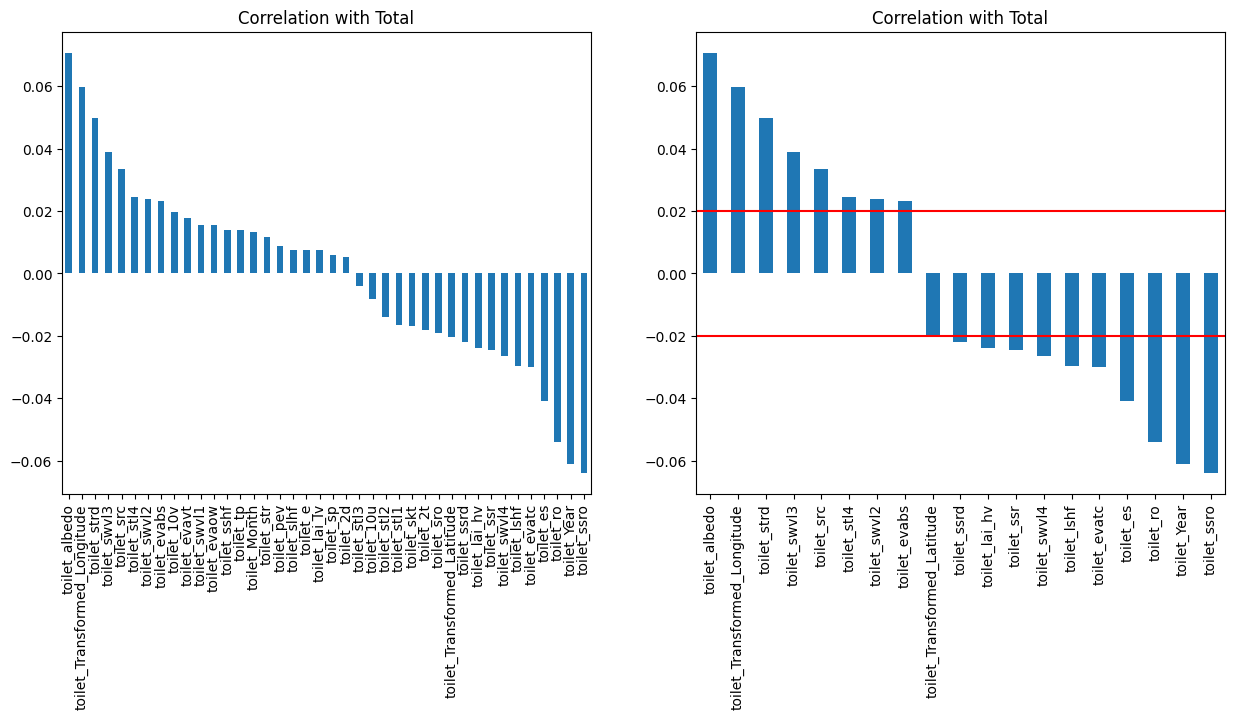

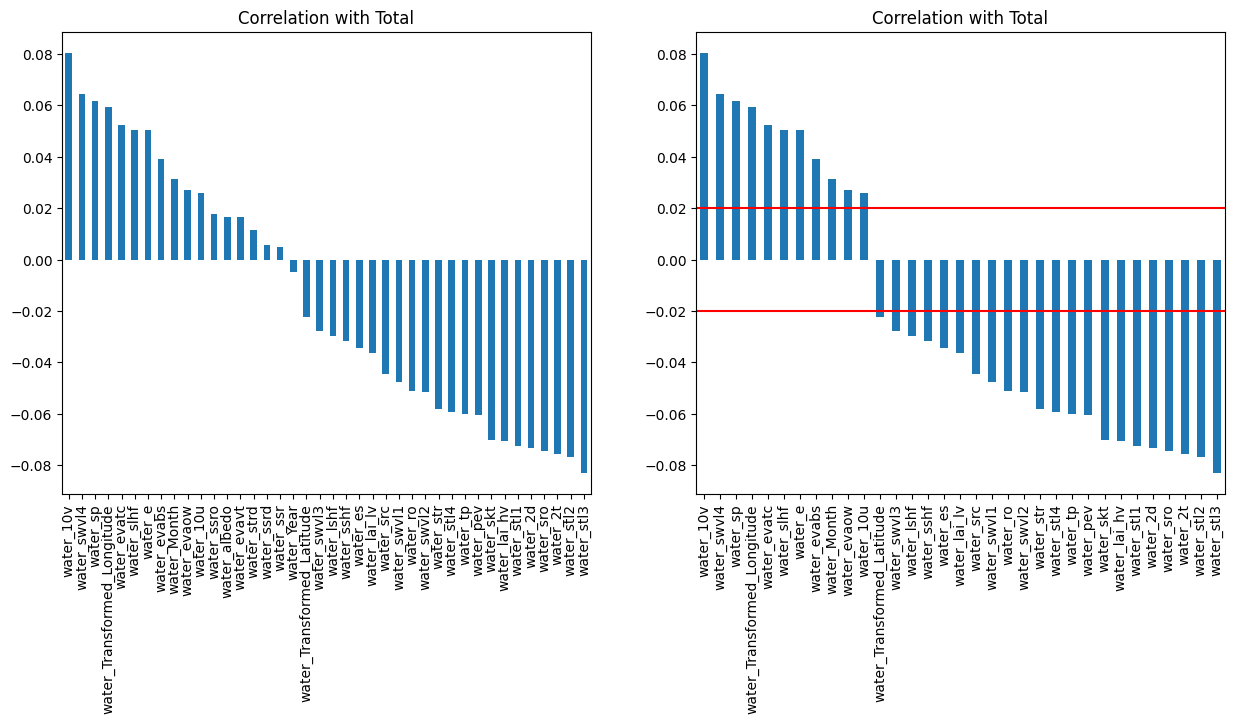

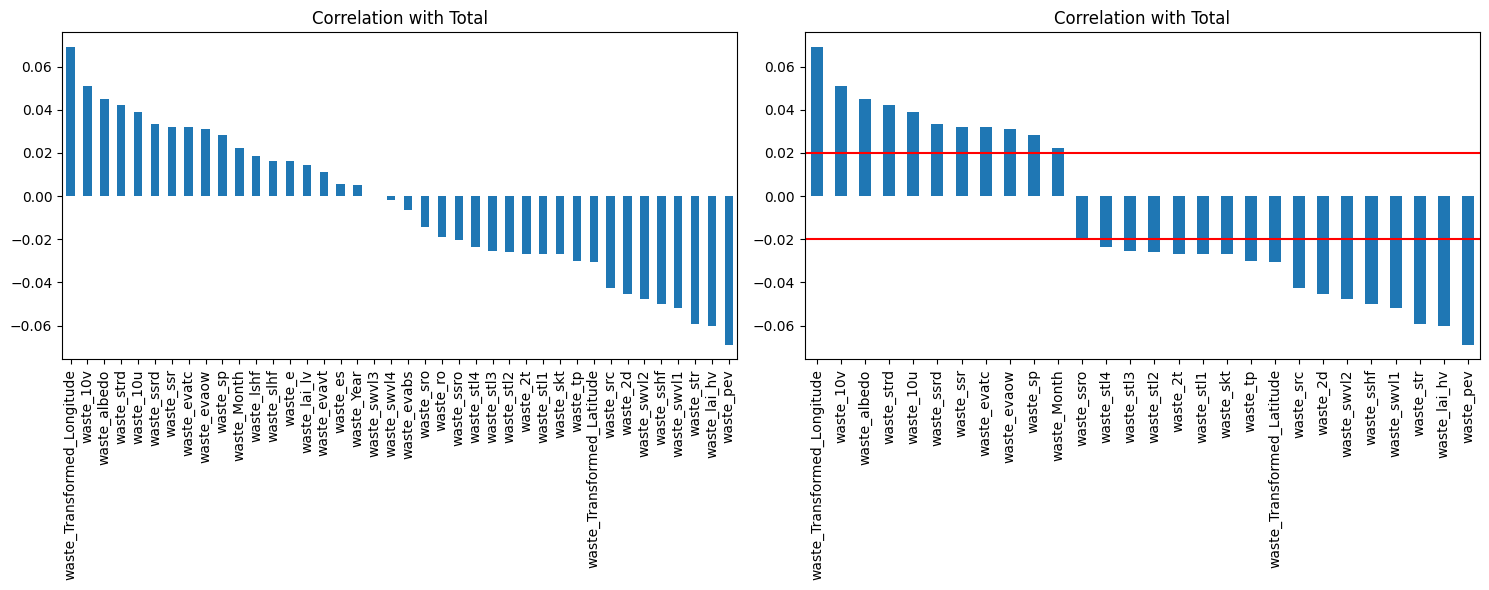

In [237]:
# List of feature prefixes
feature_prefixes = ['toilet_', 'water_', 'waste_']

# Loop through each feature prefix and plot
for col in feature_prefixes:
    strong_relation_with_target_vector(col)

plt.tight_layout()
plt.show()


$How\ do\ the\ quality\ and\ accessibility\ of\ water\ sources\ impactt\ he\ spread\ of\ waterborne\ diseases?$

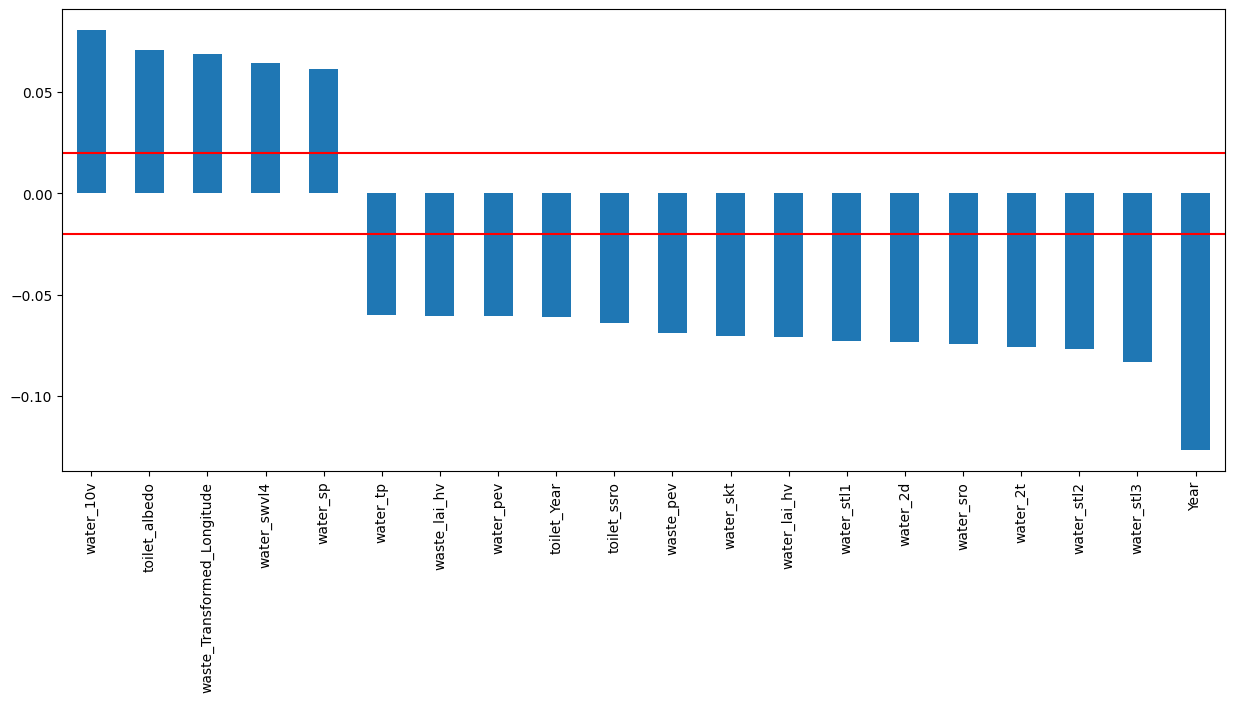

In [238]:
number_features = merged_data.select_dtypes(include=["float64", "int64"]).columns

features_corr = merged_data[number_features].corrwith(merged_data['Total']).sort_values(key= lambda x: abs(x), ascending=False)

features_corr_002 = features_corr[(features_corr > 0.02) | (features_corr < -0.02)]

features_corr_002 = features_corr_002[features_corr_002 != 1]
features_corr_002.head(20).sort_values(ascending=False).plot(kind='bar', figsize=(15, 6))
plt.axhline(y=0.02, color='r', linestyle='-')
plt.axhline(y=-0.02, color='r', linestyle='-')

<Axes: >

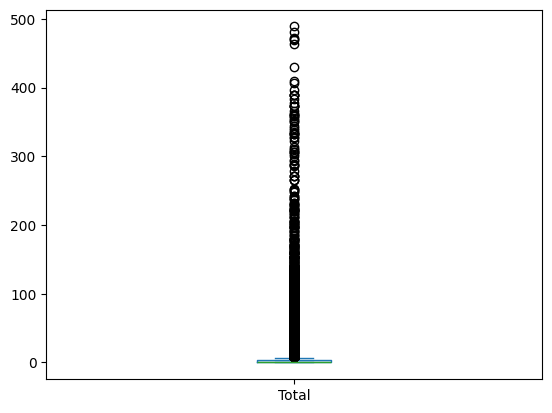

In [239]:
train_df["Total"].plot(kind="box")

In [240]:
train_df.columns.to_list()

['ID',
 'Total',
 'Location',
 'Category_Health_Facility_UUID',
 'Disease',
 'Month',
 'Year',
 'Transformed_Latitude',
 'Transformed_Longitude',
 'toilet_Month_Year_lat_lon',
 'toilet_Year',
 'toilet_Month',
 'toilet_10u',
 'toilet_10v',
 'toilet_2d',
 'toilet_2t',
 'toilet_evabs',
 'toilet_evaow',
 'toilet_evatc',
 'toilet_evavt',
 'toilet_albedo',
 'toilet_lshf',
 'toilet_lai_hv',
 'toilet_lai_lv',
 'toilet_pev',
 'toilet_ro',
 'toilet_src',
 'toilet_skt',
 'toilet_es',
 'toilet_stl1',
 'toilet_stl2',
 'toilet_stl3',
 'toilet_stl4',
 'toilet_ssro',
 'toilet_slhf',
 'toilet_ssr',
 'toilet_str',
 'toilet_sp',
 'toilet_sro',
 'toilet_sshf',
 'toilet_ssrd',
 'toilet_strd',
 'toilet_e',
 'toilet_tp',
 'toilet_swvl1',
 'toilet_swvl2',
 'toilet_swvl3',
 'toilet_swvl4',
 'toilet_Transformed_Latitude',
 'toilet_Transformed_Longitude',
 'toilet_Month_Year',
 'lat_lon_x',
 'Month_Year_lat_lon_x',
 'waste_Month_Year_lat_lon',
 'waste_Year',
 'waste_Month',
 'waste_10u',
 'waste_10v',
 'waste_2d

In [241]:
train_df["Category_Health_Facility_UUID"].nunique()

4

## Category Health Facility UUID

In [242]:
# Count values of 'Category_Health_Facility_UUID',
print(train_df["Category_Health_Facility_UUID"].value_counts())

Category_Health_Facility_UUID
a9280aca-c872-46f5-ada7-4a7cc31cf6ec    14278
b7f0a600-e19e-4c65-acb3-e28584dae35b     5621
a3761841-2a02-4c17-8589-d35aac4edc24     2497
56cd4cbb-23db-4dde-a6ae-9fc1ed7c8662     1980
Name: count, dtype: int64


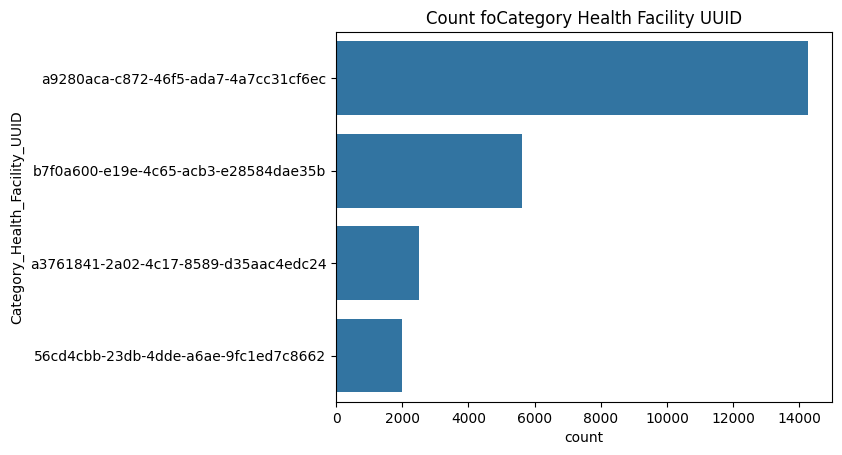

In [243]:
sns.countplot(train_df["Category_Health_Facility_UUID"])
plt.title("Count foCategory Health Facility UUID")
plt.show()

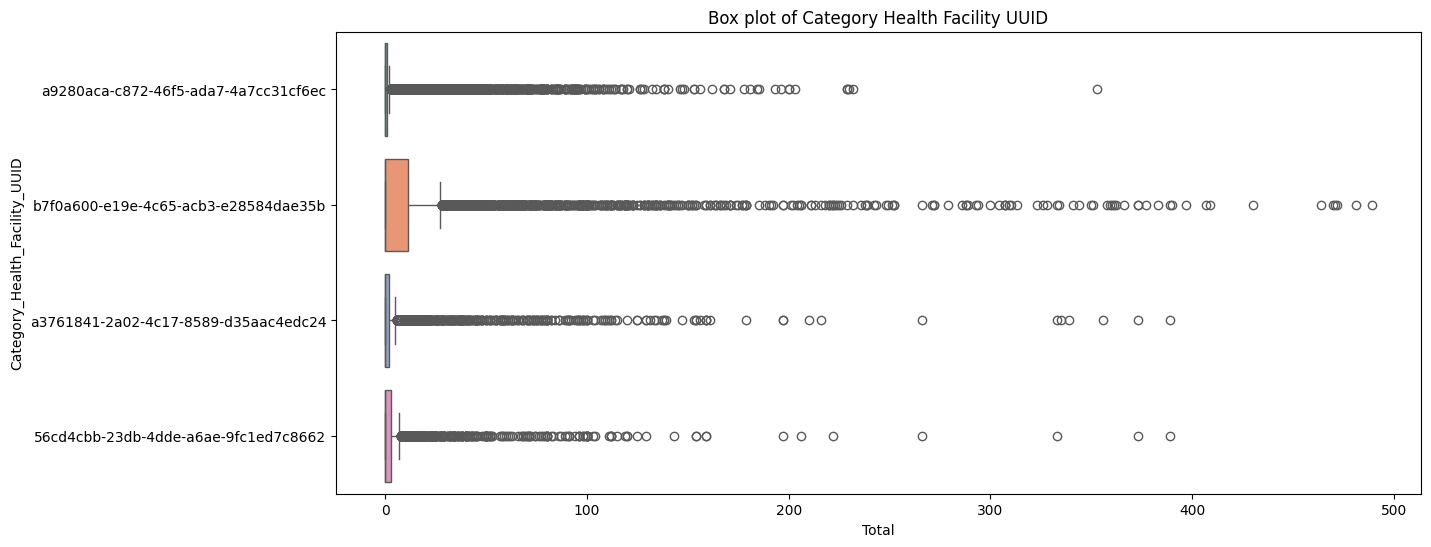

In [244]:
# Box plot of all 'Category_Health_Facility_UUID',

fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(
    data=train_df,
    x="Total",
    y="Category_Health_Facility_UUID",
    palette="Set2",
)
plt.title("Box plot of Category Health Facility UUID")
plt.show()

# Month and Year

In [245]:
train_month_year = train_df.copy()

train_df[["Month", "Year"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 24376 entries, 0 to 24375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Month   24376 non-null  int64
 1   Year    24376 non-null  int64
dtypes: int64(2)
memory usage: 571.3 KB


In [246]:
train_month_year["Month_Year"] = train_month_year["Month"].astype(str) + "-" + train_month_year["Year"].astype(str)

In [247]:
type(train_month_year_total)

pandas.core.frame.DataFrame

In [249]:
# Reset index to remove any previous index
train_month_year["Month_Year"] = train_month_year["Month"].astype(str) + "-" + train_month_year["Year"].astype(str)
train_month_year_total = train_month_year.groupby("Month_Year")["Total"].sum()


train_month_year_total = train_month_year_total.to_frame()
train_month_year_total.reset_index(inplace=True)

train_month_year_total["Month_Year"] = pd.to_datetime(train_month_year_total["Month_Year"])

train_month_year_total.sort_values(by="Month_Year", inplace=True)

# Set 'Month_Year' as the index
train_month_year_total.set_index("Month_Year", inplace=True)

# Show the first few rows of the DataFrame
print(train_month_year_total.head())

             Total
Month_Year        
2019-01-01  5958.0
2019-02-01  5727.0
2019-03-01  4467.0
2019-04-01  4679.0
2019-05-01  5066.0


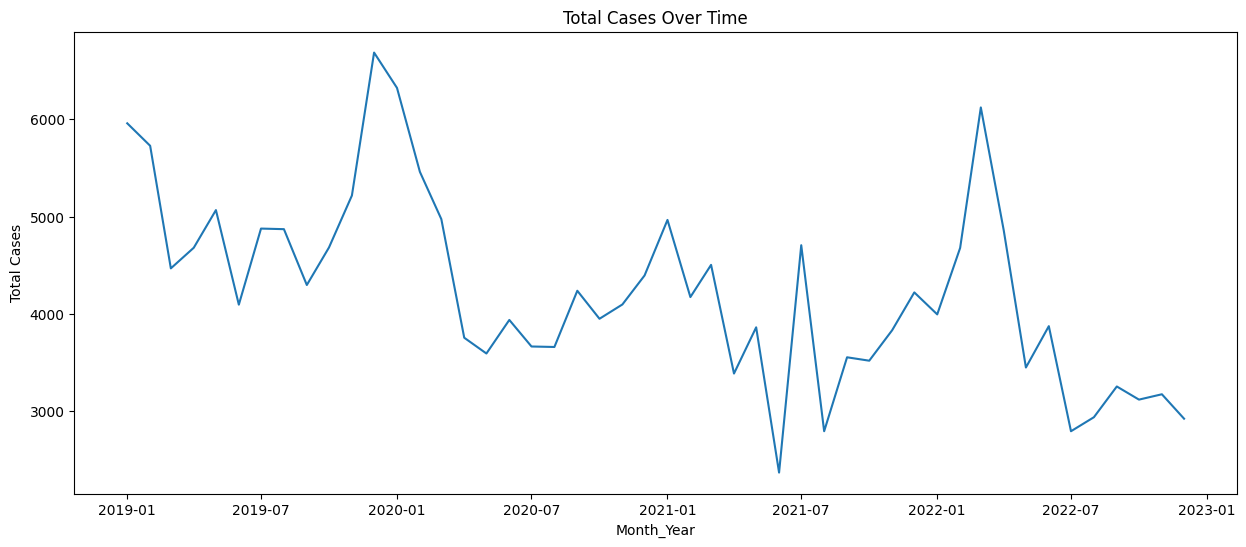

In [258]:
fig = plt.figure(figsize=(15, 6))

sns.lineplot(data=train_month_year_total, x=train_month_year_total.index, y="Total")
plt.title("Total Cases Over Time")
plt.xlabel("Month_Year")
plt.ylabel("Total Cases")

plt.show();

In [260]:
len(train_month_year_total) // 12

4